In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

class NeuralNetwork:
    def __init__(self, layerSizes, learningRate=0.01):
        
        self.layerSizes = layerSizes
        self.learningRate = learningRate

        self.weights = [] #each element is a matrix of weights between 2 layers
        self.biases = [] #each element is a vector of biases of the second layer to the last layer
    
        for i in range(len(self.layerSizes) - 1): #if we have 4 layers then we need 3 matrices for the weights and biases
            weightsMatrix = np.random.randn(layerSizes[i], layerSizes[i+1]) #this fun generates a matrix of ranodm numbers with shape (a, b), where a and b are the layer size (number of nodes), ex  [[1,2,3], [1,4,5]], means there are 2 nodes in the current layer connected to 3 nodes in the next layer
            self.weights.append(weightsMatrix) 
            biasesVector = np.random.randn(1, layerSizes[i+1]) #a row vector of baises for each layer except the first
            self.biases.append(biasesVector)


    def costFn(self, y, y_est):
        L = np.sum(y * np.log(y_est + 1e-9), axis=1) # "+ 1e-9" to avoid the operation log(0), L here is a vector of losses for each sample/digit
        L = -np.mean(L) #to output a single value showing the performance of the model overall
        return L


    def sigmoid(self, z):
        z = 1.0 / (1.0 + np.exp(-z))
        return z
    
    def sigmoidDerv(self, z):
        z_dash = self.sigmoid(z) * (1 - self.sigmoid(z))
        return z_dash

    def activationFn(self, z):
        return self.sigmoid(z)

    def softMax(self, z): #converts from range (-inf, inf) to (0, 1) which resembles probabilities
        # e_z = np.exp(z)
        # return e_z / np.sum(e_z)
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)


    def forwardProp(self, x):
    
        activations = [x]
        for i in range(len(self.weights)): #we're doing n-1 so that last layer is applied softMax and not sigmoid
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i] #z = x*w+b or = a[i-1]*w[i]+b[i] where a[i] is activationFn(z)
            if (i!=len(self.weights)-1): z_activation = self.activationFn(z) #as in sigmoid(z)
            else: z_activation = self.softMax(z) #if we're at the last layer (output), the activation is softmax and not sigmoid
            activations.append(z_activation)

        return activations

    def backProp(self, x, y, activations):
        #we'll start from the last layer and calculate each delta (dL/dw and dL/db) moving backward using chain rule
        #after we calculated all the deltas, we'll subtract them from the weights and biases, what we're doing here is the gradient decent, where we approach the minimum of the loss function

        delta_w = []
        delta_b = []
        for w in self.weights:
            delta_w.append(np.zeros_like(w)) #for each weight matrix in the list weights, we create a matrix with the same shape but filled with zeroes
        
        for b in self.biases:
            delta_b.append(np.zeros_like(b)) #same here but for biases

        for i in range (-1, -(len(self.weights)+1), -1): #we're now starting from the last layer and backpropagating to the input layer, but at the last layer (output), the delta/error is different therefore the "if" condition
            z = np.dot(activations[i-1], self.weights[i]) + self.biases[i]
            if (i==-1): delta = activations[i] - y
            else: delta = self.sigmoidDerv(z) * np.dot(delta, self.weights[i+1].T) 
            delta_b[i] = np.sum(delta)
            delta_w[i] = np.dot(activations[i-1].T, delta)

        for i in range (len(self.weights)): #we're now changing the values of weights and biases based on the deltas we calculated - which are based on the loss (how much far are the true and predicted values) -, the leanring rate determines the speed of convergence 
            self.weights[i] = self.weights[i] - self.learningRate * delta_w[i]
            self.biases[i] = self.biases[i] - self.learningRate * delta_b[i]


    def train(self, x_train, y_train, epochs, batch_size):
        for epoch in range(epochs): # 1 epoch is achieved when 1 passing of the whole input is achieved (forward then backpropagation of the whole set of inputs)
            
            
            for i in range(0, x_train.shape[0], batch_size): #we divide the input set into mini batches better computational/performance reasons
                x_batch = x_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                
                activations = self.forwardProp(x_batch)
                self.backProp(x_batch, y_batch, activations)

            if epoch % 10 == 0:  #print progress every 10 epochs
                loss = self.costFn(y_train, self.forwardProp(x_train)[-1])
                print(f"Epoch {epoch}, Loss: {loss}")

      
    def predict(self, x):
        
        output = self.forwardProp(x)[-1] #last layer which is the output
        return np.argmax(output, axis=1) #an array of the predicted values, ex: [2, 0, 4, 5] means for x1 the prediction is that it's a 2
  

Functions and derivatives used in the model:

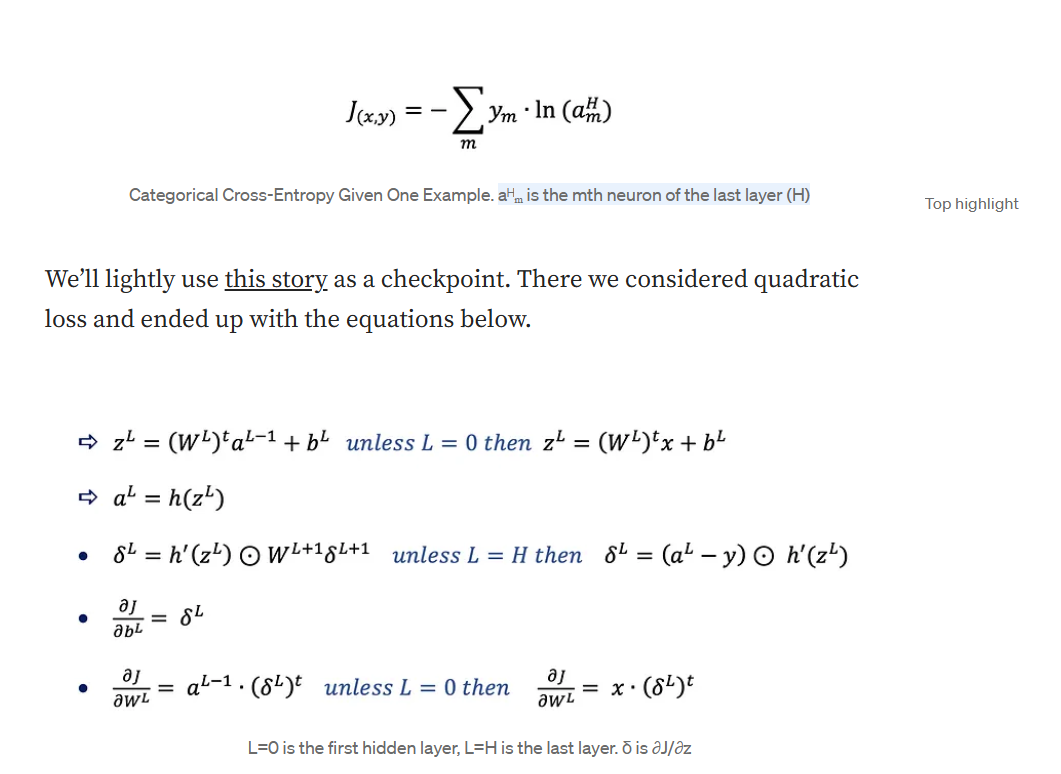

In [2]:

def preprocess(trainFile, testFile):
    train_data = pd.read_csv(trainFile)
    test_data = pd.read_csv(testFile)

    x_train = train_data.iloc[:, 1:].values  #all pixel columns (2nd to last col)
    y_train = train_data.iloc[:, 0].values   #the first column which is the label

    x_test = test_data.values

    #normalizing the pixel values to 0 and 1, by dividing by 255
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    encoder = OneHotEncoder(sparse_output=False)
    y_train = encoder.fit_transform(y_train.reshape(-1, 1))

    return x_train, y_train, x_test

def submission(predictions):

    image_ids = np.arange(1, 28000 + 1)
    submission_df = pd.DataFrame({
        'ImageId': image_ids,
        'Label': predictions
    })
    submission_df.to_csv('submission.csv', index=False)
    print(submission_df.head())


In [3]:
x_train, y_train, x_test = preprocess('train.csv', 'test.csv')
    
layer_sizes = [784, 128, 128, 10]  #input layer has 784 nodes each for each pixel, 2 hidden layers 128, output layer 10 for the 10 digits
learning_rate = 0.01
epochs = 100
batch_size = 64



In [4]:
#train the network using whole "train" dataset then predict with "test" dataset
nn = NeuralNetwork(layer_sizes, learning_rate)

print("Training the network...")
nn.train(x_train, y_train, epochs, batch_size)
print("Done training")
predictions = nn.predict(x_train)
predictions_test = nn.predict(x_test)
print("Done predicting")

submission(predictions_test)

Training the network...
Epoch 0, Loss: 0.40572877262263457
Epoch 10, Loss: 0.08519678774845643
Epoch 20, Loss: 0.035516360409268186
Epoch 30, Loss: 0.016198427871790818
Epoch 40, Loss: 0.008780245380570149
Epoch 50, Loss: 0.005675270270217916
Epoch 60, Loss: 0.004039759216949673
Epoch 70, Loss: 0.003049673872910112
Epoch 80, Loss: 0.0024019775220599227
Epoch 90, Loss: 0.0019545311567911797
Done training
Done predicting
   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      7
4        5      3


Score/Accuracy of the predicitons using test.csv submisson:

![Screenshot 2024-10-19 221744.png](<attachment:Screenshot 2024-10-19 221744.png>)
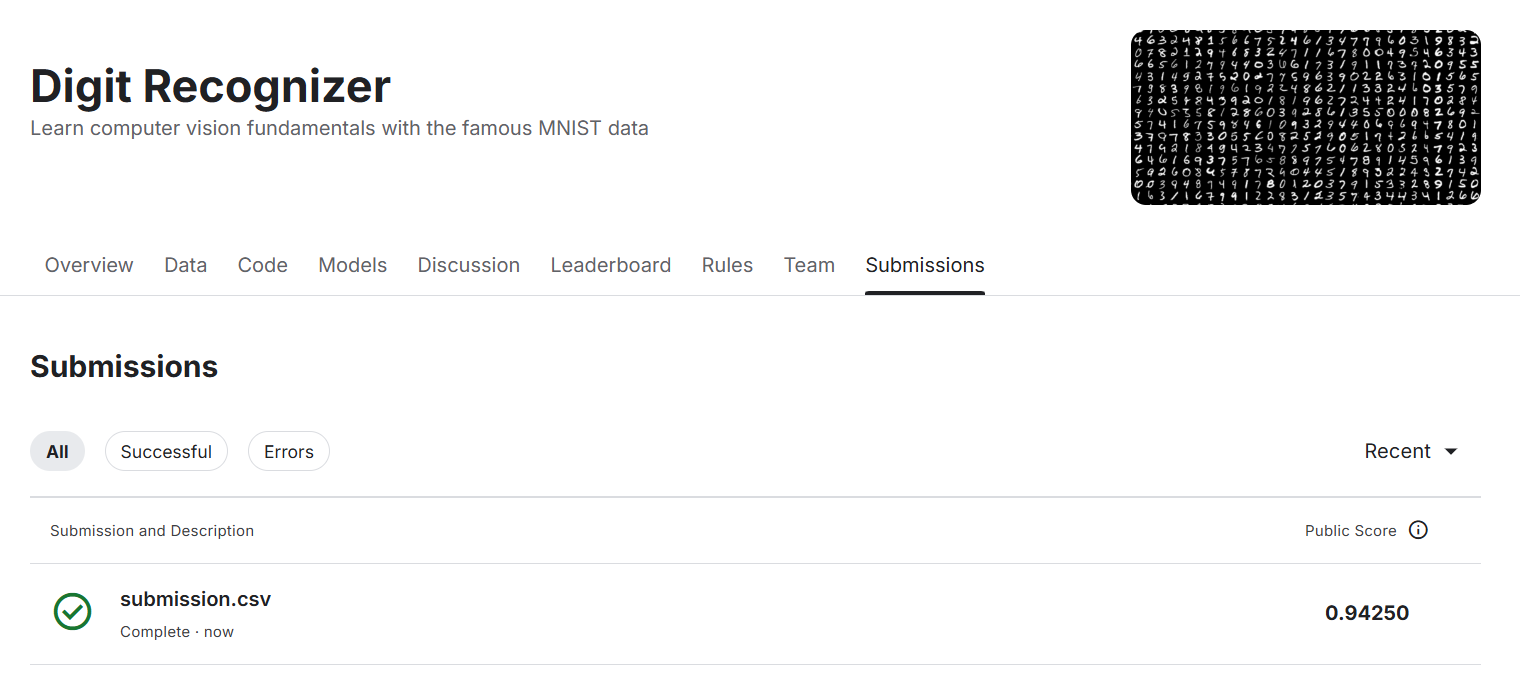

In [5]:
#train the network with part of the "train" dataset and predict with the rest of the "train" dataset

nn2 = NeuralNetwork(layer_sizes, learning_rate)

test_size = 100
x_train_1 = x_train[:][test_size:]
x_train_test = x_train[:][0:test_size]
y_train_1 = y_train[:][test_size:]
y_train_test = y_train[:][0:test_size]

print("Training the network...")
nn2.train(x_train_1, y_train_1, epochs, batch_size)
print("Done training")
predictions = nn2.predict(x_train_test)
print("Done predicting")
# print(predictions[0:test_size])



Training the network...
Epoch 0, Loss: 0.39048778592524763
Epoch 10, Loss: 0.09595940124935058
Epoch 20, Loss: 0.039538145251584236
Epoch 30, Loss: 0.019278855509729666
Epoch 40, Loss: 0.010202734860953433
Epoch 50, Loss: 0.006050022709769868
Epoch 60, Loss: 0.00401582819299257
Epoch 70, Loss: 0.0029118369135481444
Epoch 80, Loss: 0.0022454314023703727
Epoch 90, Loss: 0.0018179234668788053
Done training
Done predicting


In [6]:
print(np.argmax(y_train_test, axis=1))
print(predictions)

[1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2 0 7 5 8 6 2 0 2 3 6 9 9 7 8 9 4 9 2 1 3
 1 1 4 9 1 4 4 2 6 3 7 7 4 7 5 1 9 0 2 2 3 9 1 1 1 5 0 6 3 4 8 1 0 3 9 6 2
 6 4 7 1 4 1 5 4 8 9 2 9 9 8 9 6 3 6 4 6 2 9 1 2 0 5]
[1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2 0 7 6 8 6 2 0 2 3 6 9 9 7 8 9 4 9 2 1 3
 1 1 4 5 1 4 4 2 6 8 7 7 4 7 5 1 9 0 2 2 3 9 1 1 1 5 0 6 3 4 8 1 0 3 9 6 2
 6 4 7 1 4 1 5 4 8 9 2 8 9 8 9 0 3 6 4 6 2 7 1 2 0 5]


In [7]:
accuracy = accuracy_score(np.argmax(y_train_test, axis=1), predictions)
print(f"Accuracy: {100*accuracy}%")

Accuracy: 94.0%


Resources that helped me:

https://towardsdatascience.com/deriving-backpropagation-with-cross-entropy-loss-d24811edeaf9
https://www.simplilearn.com/tutorials/machine-learning-tutorial/what-is-epoch-in-machine-learning
https://numpy.org/doc/stable/user/index.html#user
https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.accuracy_score.html